In [393]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read in Data 

In [394]:
def pr(df):
    p = pandas_profiling.ProfileReport(df)
    return p  

In [395]:
DATA = "Data/jan18.csv"

In [396]:
jan18 = pd.read_csv(DATA)

In [397]:
smart_cols = ['sex', 'hisp', 'age', 'educ2', 'inc', 'racem1', 'smart2']
dep_cols = smart_cols+['home4nw'] #home broadband
use_social = ['web1a','web1b', 'web1c', 'web1d', 'web1e', 'web1f', 'web1g', 'web1h']
social_freq = ['sns2a', 'sns2b', 'sns2c', 'sns2d', 'sns2e']
giveup = ['pial5a', 'pial5b', 'pial5c', 'pial5d']
good_or_bad = ['pial11']
all_cols = dep_cols + use_social + social_freq + giveup + good_or_bad

In [398]:
jan18_smart = pd.read_csv(DATA, usecols = smart_cols)
jan18_dep = pd.read_csv(DATA, usecols = dep_cols)
jan18_full = pd.read_csv(DATA, usecols = all_cols)

In [399]:
def pct(series, xlabel='', ylabel='', title=''):
    '''
    Return series of percentage distribution & histogram.
    '''
    vals = series.value_counts()
    s = vals/sum(vals)*100
    
    s.plot(kind = 'bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

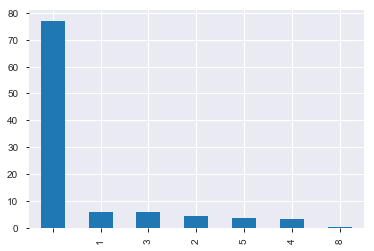

In [400]:
pct(jan18_full['sns2a'])

## Cleaning 

In [401]:
def mapping(df, orig, new, d):
    '''
    Map values. Print new histogram.
    '''
    series = df[orig]
    series_new = series.map(d)
    
    new_df = df.drop(orig, axis = 1, inplace = False)
    new_df[new] = series_new
    return new_df

### Map

#### Age 

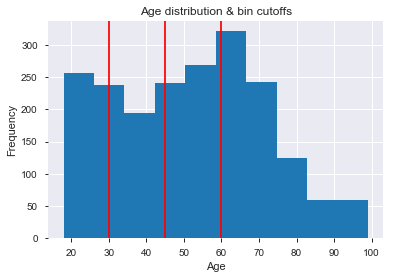

In [402]:
ax = jan18_smart['age'].plot(kind = 'hist')
plt.xlabel('Age')
plt.title('Age distribution & bin cutoffs')

for xi in [30,45,60]:
    ax.axes.axvline(x=xi, color = 'r')
plt.savefig('age.png')

In [403]:
'''
def age(df):
    
    def bin_age(df, lower, upper, new):
        # If lower < age <= upper put in bin 'new'.
        df.loc[(df['age'] > lower) & (df['age']<= upper), 'age'] = new

    lun = [(0, 30, 1), (30, 45,2), (45, 60, 3), (60, 97, 4), (97, 100, 0)] 
    # sets of lower upper and new

    for l, u, n in lun:
        bin_age(df, l, u, n)
'''

"\ndef age(df):\n    \n    def bin_age(df, lower, upper, new):\n        # If lower < age <= upper put in bin 'new'.\n        df.loc[(df['age'] > lower) & (df['age']<= upper), 'age'] = new\n\n    lun = [(0, 30, 1), (30, 45,2), (45, 60, 3), (60, 97, 4), (97, 100, 0)] \n    # sets of lower upper and new\n\n    for l, u, n in lun:\n        bin_age(df, l, u, n)\n"

In [404]:
'''
for d in dfs:
age(d)
'''

'\nfor d in dfs:\nage(d)\n'

In [405]:
def new_df(df, l):
    '''
    Return the new df.
    '''
    orig, new, d = l
    new = mapping(df, orig, new, d)
    return new

In [406]:
def loop(df, lists):
    '''
    Loop over lists doing transforms.
    '''
    for l in lists:
        new = new_df(df, l)
        df = new
    return df

In [407]:
smart_d = {'1' : 1, '2': 2, ' ':3, '8':0, '9':0}
smart = ['smart2', 'phone', smart_d]
# blank means landline sample and answered no to Device1a ("do you have a cell phone?"). Hence, values are strings.

educ_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 98: 0, 99: 0}
educ = ['educ2', 'educ', educ_d]

hisp_d = {1:1, 2:2, 8:0, 9:0}
hisp = ['hisp', 'non_hisp', hisp_d]

inc_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 98: 0, 99: 0}
inc = ['inc', 'inc', inc_d]

race_d = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:0, 9:0}
race = ['racem1', 'race', race_d]

In [408]:
dep_d = {'1' : 1, '2': 2, ' ':3, '8':0}
dep = ['home4nw', 'broadband', dep_d]

In [409]:
lists = [smart, educ, hisp, inc, race]

In [410]:
df = loop(jan18_smart, lists)

In [411]:
lists_dep = [smart, educ, hisp, inc, race, dep]

In [412]:
df_dep = loop(jan18_dep, lists_dep)

### Remove rows with zeros 

In [413]:
def remove_zero_rows(df):
    '''
    Return Data Frame with zero rows removed and index reseted.
    '''
    removed = df[(df != 0).all(1)]
    
    reset = removed.reset_index(drop=True)
    
    return reset

In [414]:
df = remove_zero_rows(df)
df_dep = remove_zero_rows(df_dep)

### Binarize 

#### Race 

In [415]:
from sklearn.preprocessing import OneHotEncoder

In [416]:
def binarize(df, col, val_names, leave_out=True):
    ''' 
    Given a Data Frame, a column name and its value names, binarizes that column in the data frame.
    If leave_out is true, you remove the last
    '''
    series = df[col]
    array_2d = series.values.reshape(-1,1)
    
    enc = OneHotEncoder()
    array = enc.fit(array_2d).transform(array_2d).toarray()
    df_col = pd.DataFrame(array, columns = val_names)
    
    
    dropped_df = df.drop(col, axis = 1, inplace = False)
    new_df = pd.concat([dropped_df, df_col], axis = 1)
    
    if leave_out:
        new_df.drop(val_names[-1], axis=1, inplace = True)  
    
    return new_df

In [417]:
races = ['White', 'Black', 'Asian', 'Other', 'Native', 'Island', 'Hispanic']
races = [i.lower() for i in races]

In [418]:
new_df = binarize(df, 'race', races)
new_df_dep = binarize(df_dep, 'race', races)

#### Label 

In [419]:
smart_bin_d = {1 : 1, 2: 0, 3:0}
smart_bin = ['phone', 'smart_bin', smart_bin_d]

In [420]:
df = mapping(new_df, smart_bin[0], smart_bin[1], smart_bin[2])

In [421]:
phone_names = ['smart', 'dumb', 'none']
broadband_names = ['home', 'outside home', 'no internet']

dependence = pd.crosstab(index = new_df_dep['phone'], columns = new_df_dep['broadband'], normalize = True)

In [422]:
dependence.columns = broadband_names

In [423]:
dependence.index = phone_names

In [424]:
dependence

,home,outside home,no internet
smart,0.674699,0.119214,0.017121
dumb,0.083069,0.032340,0.045022
none,0.007609,0.001268,0.019658


In [425]:
new_df_dep['dep'] = 0
new_df_dep.loc[((new_df_dep['broadband'] == 2) | (new_df_dep['broadband'] == 3)) & (new_df_dep['phone']==1), 'dep'] = 1
df_dep = new_df_dep.drop(['phone', 'broadband'], axis = 1)

## Logistic Regression

In [426]:
def split(df, label):
    y = df[label].values
    X = df.drop(label, axis = 1).values
    return X, y

In [427]:
import statsmodels.api as sm
import numpy as np

def log_reg(X, y, yname, xnames):
    '''
    Given X and y and their names, print out Logistic Regression results
    '''
    
    # Add a constant to the numpy array
    num_obs = X.shape[0]
    const_vec = np.ones(num_obs).reshape((num_obs, 1))
    XplusConst = np.hstack((const_vec, X))

    # Run Model
    LogitModel = sm.Logit(y, XplusConst)
    LogitReg_sm = LogitModel.fit()
    res = LogitReg_sm
    print(LogitReg_sm.summary(yname, ['const']+xnames, 'Logistic Regression'))
    
    return res

In [428]:
def run_LR(df, label):
    '''
    Given name of label column, run LR.
    '''
    
    X, y = split(df, label)
    
    xnames = list(df.columns.drop(label))
    
    lr = log_reg(X, y, label, xnames)
    
    return lr

### Smartphone

In [429]:
def sig_plot(df, lr, image_name):
    
    '''
    Given Regression results, save a significance plot of the variables.
    Thanks to https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/.
    '''
    err_series = lr.params - lr.conf_int()[:,0]
    err = err_series[1:]
    params = lr.params[1:]
    
    names = df.columns[:-1]
    
    coef_df = pd.DataFrame({'coef': params,
                        'err': err,
                        'varname': names
                       })
    
    fig, ax = plt.subplots(figsize=(8, 5))
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('Beta')
    ax.set_xlabel('Variable')
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    _ = ax.set_xticklabels(names, 
                           rotation=0, fontsize=12)
    plt.savefig(image_name, bbox_inches='tight')
    
    return

In [430]:
df = df.drop(['island'], axis = 1)

In [431]:
lr = run_LR(df, 'smart_bin')

Optimization terminated successfully.
         Current function value: 0.367908
         Iterations 8
                             Logistic Regression                              
Dep. Variable:              smart_bin   No. Observations:                 1583
Model:                          Logit   Df Residuals:                     1572
Method:                           MLE   Df Model:                           10
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:                  0.2422
Time:                        00:48:03   Log-Likelihood:                -582.40
converged:                       True   LL-Null:                       -768.57
                                        LLR p-value:                 7.145e-74
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0207      0.494      6.113      0.000       2.052       3.989
sex           -0.0298      0.

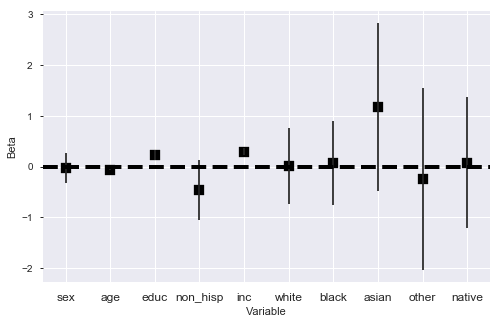

In [432]:
sig_plot(df, lr, 'smart')

### Dependence 

In [433]:
df_dep = df_dep.drop(['island'], axis = 1)

In [434]:
lr = run_LR(df_dep, 'dep')

Optimization terminated successfully.
         Current function value: 0.335734
         Iterations 7
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1577
Model:                          Logit   Df Residuals:                     1566
Method:                           MLE   Df Model:                           10
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:                  0.1570
Time:                        00:48:03   Log-Likelihood:                -529.45
converged:                       True   LL-Null:                       -628.05
                                        LLR p-value:                 6.225e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4900      0.450      5.539      0.000       1.609       3.371
sex           -0.2264      0.

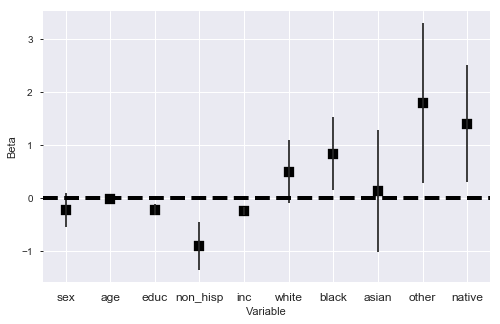

In [435]:
sig_plot(df, lr, 'dep')

In [436]:
discrete_margins = lr.get_margeff()

In [437]:
discrete_margins.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0229      0.016     -1.393      0.164      -0.055       0.009
x2            -0.0019      0.000     -4.192      0.000      -0.003      -0.001
x3            -0.0225      0.005     -4.148      0.000      -0.033      -0.012
x4            -0.0913      0.023     -3.944      0.000      -0.137      -0.046
x5            -0.0246      0.004     -6.589      0.000      -0.032      -0.017
x6             0.0504      0.031      1.643      0.100      -0.010       0.110
x7             0.0845      0.035      2.395      0.017       0.015       0.154
x8             0.0134      0.059      0.226      0.821      -0.103       0.130
x9             0.1813      0.078      2.332      0.020       0.029       0.334
x10            0.1415      0.057      2.494      0.013       0.030       0.253
==============================================================================
"""

In [438]:
def univariate(df, col, label):
    '''
    Given data frame and name of predictor and label, output logistic regression.
    '''
    
    TO_DROP = df.columns.drop([label, col])
    col_df = df.drop(TO_DROP, axis = 1)
    
    LR = run_LR(col_df, label)
    
    return LR

In [439]:
lr = univariate(df_dep, 'age', 'dep')

Optimization terminated successfully.
         Current function value: 0.388122
         Iterations 6
                             Logistic Regression                              
Dep. Variable:                    dep   No. Observations:                 1577
Model:                          Logit   Df Residuals:                     1575
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Jul 2019   Pseudo R-squ.:                 0.02544
Time:                        00:48:04   Log-Likelihood:                -612.07
converged:                       True   LL-Null:                       -628.05
                                        LLR p-value:                 1.577e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7597      0.200     -3.797      0.000      -1.152      -0.368
age           -0.0228      0.

## ML 

In [440]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [441]:
X = df_dep.drop('dep', axis = 1)
y = df_dep['dep']

In [442]:
X_v = X.values
y_v = y.loc[:,].values

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X_v, y_v, test_size = .3,
                                                    random_state=25)

In [444]:
def run_ML(model, X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    score = round(model.score(X_test, y_test) * 100,2)
    print('accuracy score:', score)
    return score

### Logistic Regression  

In [445]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

             precision    recall  f1-score   support

          0       0.88      1.00      0.93       412
          1       0.67      0.06      0.12        62

avg / total       0.85      0.87      0.83       474



In [446]:
score = round(model.score(X_test, y_test) * 100,2)
print('accuracy score:', score)

accuracy score: 87.34


In [447]:
acc_log = round(LogReg.score(X_test, y_test) * 100,2)
acc_log

87.340000000000003

In [448]:
LogReg = LogisticRegression()
acc_log = run_ML(LogReg)

             precision    recall  f1-score   support

          0       0.88      1.00      0.93       412
          1       0.67      0.06      0.12        62

avg / total       0.85      0.87      0.83       474

accuracy score: 87.34


In [449]:
acc_log

87.340000000000003

In [450]:
LogReg.coef_

array([[-0.03763877, -0.01490408, -0.25881728, -0.66844957, -0.22175602,
         0.39798798,  0.66664481, -0.52233572,  0.1231662 ,  1.15931818]])

In [451]:
LogReg.intercept_

array([ 1.87831009])

### DT 

In [452]:
decision_tree = DecisionTreeClassifier()
acc_dt=run_ML(decision_tree)

             precision    recall  f1-score   support

          0       0.90      0.86      0.88       412
          1       0.27      0.34      0.30        62

avg / total       0.81      0.79      0.80       474

accuracy score: 79.11


### Random Forest 

In [453]:
rf = RandomForestClassifier(n_estimators=500)
acc_rf = run_ML(rf)

             precision    recall  f1-score   support

          0       0.89      0.95      0.92       412
          1       0.44      0.26      0.33        62

avg / total       0.84      0.86      0.84       474

accuracy score: 86.08


### SVC

In [454]:
svc = LinearSVC()
acc_linear_svc = run_ML(rf)

             precision    recall  f1-score   support

          0       0.89      0.95      0.92       412
          1       0.43      0.24      0.31        62

avg / total       0.83      0.86      0.84       474

accuracy score: 85.86


### KNN 

In [455]:
knn = KNeighborsClassifier()
acc_knn = run_ML(knn)

             precision    recall  f1-score   support

          0       0.88      0.95      0.92       412
          1       0.34      0.16      0.22        62

avg / total       0.81      0.85      0.83       474

accuracy score: 85.02


### Table 

In [456]:
accuracy = [acc_log, acc_dt, acc_rf, acc_linear_svc, acc_knn]

In [457]:
res = pd.DataFrame({
'accuracy' : accuracy,
'model':['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Classifier', 'K Nearest Neighbors'],
}
)

In [458]:
res.sort_values(by='accuracy', ascending=False, inplace=True)

In [459]:
export = res[['model', 'accuracy']]
export

,model,accuracy
0,Logistic Regression,87.34
2,Random Forest,86.08
3,Support Vector Classifier,85.86
4,K Nearest Neighbors,85.02
1,Decision Tree,79.11


TODO: make table nicer

### Interpreting Logistic Regression 

In [460]:
crosstab = pd.crosstab(index = df['sex'], columns = df['smart_bin'], normalize = True)

In [461]:
sex = ['male', 'female']
smart = ['no smartphone', 'smartphone']


In [462]:
crosstab.columns = smart
crosstab.index = sex

In [463]:
crosstab

,no smartphone,smartphone
male,0.087808,0.455464
female,0.101706,0.355022


Text(0.5,1,'Gender & Smartphone ownership')

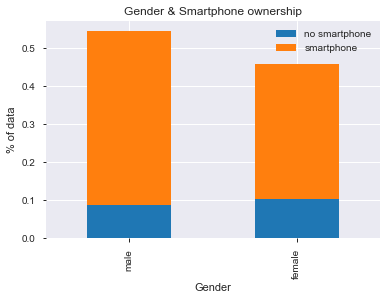

In [464]:
crosstab.plot.bar(stacked=True)
plt.ylabel('% of data')
plt.xlabel('Gender')
plt.title('Gender & Smartphone ownership')

In [465]:
male = crosstab.iloc[0]
fem = crosstab.iloc[1]

In [466]:
male_smart = male[1]/male[0]
female_smart = fem[1]/fem[0]

In [467]:
male_smart

5.1870503597122299

In [468]:
female_smart

3.4906832298136647

In [469]:
female_to_male= female_smart/male_smart

In [470]:
female_to_male

0.67296112197517255

In [471]:
np.exp(female_to_male)

1.9600326317878216

In [472]:
log_male = np.log(male_smart)
log_male

1.6461652041542572